<a href="https://colab.research.google.com/github/thaopham03/evaluating_fan_effects_in_large_language_models/blob/main/fan_effects_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import ast

from scipy.stats import spearmanr, pearsonr

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def filtering(file_name):

  # Assume all the results file are located in this dir:
  loc = "/content/drive/MyDrive/IGOG-Alignment-Exp/Experiments/fan-effects-exp/results/rational/"

# Filter out the elements from the result:

  truep_t = []  # true present, typical
  truep_at = [] # true present, atypical
  falsep_t = []  # false present, typical
  falsep_at = []  # false present, atypical
  truea_t = []  # true absent, typical
  truea_at = [] # true absent, atypical
  falsea_t = []  # false absent, typical
  falsea_at = [] # false absent, atypical

  # List of typical members:
  typical_members = ["robin","sparrow","bluejay","bluebird","canary","blackbird","dove","lark","swallow","parakeet","oriole","mockingbird","redbird", "wren",
                    "finch","starling","cardinal","eagle","hummingbird","seagull","woodpecker","pigeon","thrush","falcon","crow","hawk","raven"]

  # List of atypical members:
  atypical_members = ["goldfinch","parrot","sandpiper","pheasant","catbird","crane","albatross","condor","toucan","owl","pelican","goose","vulture",
                      "stork","buzzard","swan","flamingo","duck","peacock","egret","chicken","turkey","ostrich","titmouse","emu","penguin","bat"]

  # Read the csv file:
  read_stimulus = pd.read_csv(loc+file_name,usecols=['stimulus'])
  read_item = pd.read_csv(loc+file_name,usecols=['item'])
  read_preamble = pd.read_csv(loc+file_name,usecols=['preamble'])
  read_score_val = pd.read_csv(loc+file_name,usecols=["score (sum, mean, [list)"])

  # Split preamble into a list of just only items
  read_preamble['split_preamble'] = read_preamble['preamble'].apply(lambda x: x.split(".")[0][15:].split(", "))

  for i in range(len(read_item)):
    item = read_item.at[i, 'item']
    # split_preamble = read_preamble['preamble'].apply(lambda x: x.split(".")[0][15:].split(", "))
    # split_preamble = split_preamble[15:].split(", ")
    split_preamble = read_preamble.at[i, 'split_preamble']
    # preamble = read_preamble[i, 'split_preamble']
    stimulus = read_stimulus.at[i, 'stimulus']
    score_val = read_score_val.at[i, "score (sum, mean, [list)"]

    if isinstance(score_val, str):
      # Extracting the mean value from the score string
      score_val = score_val.strip('[]()').split(',')[1].strip()
      score_val = float(score_val)

    if item in split_preamble and stimulus == "present.":  # true present
      if item in typical_members:
        truep_t.append(score_val)
      elif item in atypical_members:
        truep_at.append(score_val)
    elif item in split_preamble and stimulus == "absent.": # false absent
      if item in typical_members:
        falsea_t.append(score_val)
      elif item in atypical_members:
        falsea_at.append(score_val)
    elif item not in split_preamble and stimulus == "present.": # false present
      if item in typical_members:
        falsep_t.append(score_val)
      elif item in atypical_members:
        falsep_at.append(score_val)
    elif item not in split_preamble and stimulus == "absent.": # true absent
      if item in typical_members:
        truea_t.append(score_val)
      elif item in atypical_members:
        truea_at.append(score_val)
  # Visualization

  # Create a dictionary to store the lists
  map_df = {
      'true_p_typical': truep_t,
      'true_p_atypical': truep_at,
      'false_p_typical': falsep_t,
      'false_p_atypical': falsep_at,
      'true_a_typical': truea_t,
      'true_a_atypical': truea_at,
      'false_a_typical': falsea_t,
      'false_a_atypical': falsea_at
  }

  # Check the lengths of all lists
  list_lengths = [len(lst) for lst in map_df.values()]

  # Ensure all lengths are equal
  max_length = max(list_lengths)
  for lst in [truep_t, truep_at, falsep_t, falsep_at, truea_t, truea_at, falsea_t, falsea_at]:
      if len(lst) < max_length:
          # Fill missing values with NaN
          lst += [np.nan] * (max_length - len(lst))


  # Convert the dictionary to a DataFrame
  df = pd.DataFrame(map_df)
  print(df)


In [ ]:
def main():
  print("Mistral")
  filtering('mistralai_Mistral-7B-v0.1.csv')
  print("Llama-2")
  filtering('meta-llama_Llama-2-7b-hf.csv')
  print("Llama-3")
  filtering('meta-llama_Meta-Llama-3-8B.csv')

if __name__ == "__main__":
  main()

Mistral
     true_p_typical  true_p_atypical  false_p_typical  false_p_atypical  \
0         -9.099177        -3.295715        -9.209574         -9.275753   
1         -8.862229        -3.891313        -8.461470         -8.345871   
2         -9.323246        -8.800889        -8.458887         -9.848536   
3        -10.051567        -7.738414        -8.897091         -9.486038   
4         -9.397378        -9.446735        -7.753295         -8.804101   
..              ...              ...              ...               ...   
398             NaN              NaN        -8.450175               NaN   
399             NaN              NaN        -9.474573               NaN   
400             NaN              NaN        -7.604613               NaN   
401             NaN              NaN       -10.382090               NaN   
402             NaN              NaN        -9.142367               NaN   

     true_a_typical  true_a_atypical  false_a_typical  false_a_atypical  
0        -10.1246

In [9]:
def load_data(data_file, drop_cols=[''], convert_prob=True):
  data = pd.read_csv(data_file)

  try:
      data["score (sum, mean, [list)"] = [[t[1] for t in m] for m in data["score (sum, mean, [list)"].apply(ast.literal_eval)]
  except ValueError as e:
      for m in data["score (sum, mean, [list)"]:
          print(m)
      print(data["score (sum, mean, [list)"])
      return None

  if convert_prob:
      data["score (sum, mean, [list)"] = [[(2 ** t) for t in m] for m in data["score (sum, mean, [list)"]]

  return pd.DataFrame(data)

# load_data('/content/drive/MyDrive/IGOG-Alignment-Exp/Experiments/fan-effects-exp/results/rational/mistralai_Mistral-7B-v0.1.csv', convert_prob=True)

In [10]:
def split_confusion_matrix(df):
    test_pos = df.loc[(df['Stimulus'] == 'present')]
    test_neg = df.loc[(df['Stimulus'] == 'absent')]

    # df['presentInContext'] = df.apply(
    #   lambda row: row['preamble'].count(row['item'])>1, # returns true if the item is in the context
    #   axis=1)

    true_neg  = test_neg.loc[(test_neg['True_Category'] ==  'absent')].reset_index()
    false_pos = test_pos.loc[(test_pos['True_Category'] ==  'absent')].reset_index()
    false_neg = test_neg.loc[(test_neg['True_Category'] == 'present')].reset_index()
    true_pos  = test_pos.loc[(test_pos['True_Category'] == 'present')].reset_index()

    # Decided to return in the same order expected from sklearn confusion_matrix function
    return true_neg, false_pos, false_neg, true_pos

In [ ]:
# def split_confusion_matrix(df):
#   test_pos = df.loc[(df['stimulus'] == 'present.')]
#   test_neg = df.loc[(df['stimulus'] == 'absent.')]
#   # print(test_pos)
#   # print(test_neg)

#   # Initialize empty DataFrames for the confusion matrix components
#   true_pos = pd.DataFrame(columns=df.columns)
#   false_pos = pd.DataFrame(columns=df.columns)
#   true_neg = pd.DataFrame(columns=df.columns)
#   false_neg = pd.DataFrame(columns=df.columns)

#   # Check if item is true_pos or false_pos in test_pos:
#   for i, row in test_pos.iterrows():
#     preamble_items = row['preamble'].split(".")[0][15:].split(", ")
#     if row['item'] in preamble_items:
#       true_pos = pd.concat([true_pos, pd.DataFrame([row])], ignore_index=True)
#     else:
#       false_pos = pd.concat([false_pos, pd.DataFrame([row])], ignore_index=True)

#   # Check if item is true_neg or false_neg in test_neg:
#   for i, row in test_neg.iterrows():
#     preamble_items = row['preamble'].split(".")[0][15:].split(", ")
#     if row['item'] in preamble_items:
#         true_neg = pd.concat([true_neg, pd.DataFrame([row])], ignore_index=True)
#     else:
#         false_neg = pd.concat([false_neg, pd.DataFrame([row])], ignore_index=True)

#   # Reset index for all DataFrames
#   true_pos = true_pos.reset_index(drop=True)
#   false_pos = false_pos.reset_index(drop=True)
#   true_neg = true_neg.reset_index(drop=True)
#   false_neg = false_neg.reset_index(drop=True)

#   # read_preamble['split_preamble'] = read_preamble['preamble'].apply(lambda x: x.split(".")[0][15:].split(", "))


#   # true_neg  = test_neg.loc[(test_neg['True_Category'] ==  'absent.')].reset_index()
#   # false_pos = test_pos.loc[(test_pos['True_Category'] ==  'absent.')].reset_index()
#   # false_neg = test_neg.loc[(test_neg['True_Category'] == 'present.')].reset_index()
#   # true_pos  = test_pos.loc[(test_pos['True_Category'] == 'present.')].reset_index()

#   # Decided to return in the same order expected from sklearn confusion_matrix function
#   return true_neg, false_pos, false_neg, true_pos

#   """
#   # Jesse's code to check if the member is in the context:
#   df['presentInContext'] = df.apply(
#       lambda row: row['preamble'].count(row['item'])>1, # returns true if the item is in the context
#       axis=1)
#   """
# # rand_mist = load_data('/content/drive/MyDrive/IGOG-Alignment-Exp/Experiments/fan-effects-exp/results/rational/mistralai_Mistral-7B-v0.1.csv', convert_prob=True)
# # split_confusion_matrix(rand_mist)

In [5]:
def confusion_scatter(df, fan_type = 'both', aggregate='none'):
  if fan_type == 'both':
      fan = lambda a, b : (a*a + b*b)**(1/2)
  elif fan_type == 'first':
      fan = lambda a, b : a
  elif fan_type == 'second':
      fan = lambda a, b : b

  def fill_subplot(ax, df_part : pd.DataFrame, lab):
      x = []   # typicality rank
      y = []   # probs

      for _, row in df_part.iterrows():
        fan_per = row['Rank']
        # fan_pla = row['Fan_Place']
        probs = row["score (sum, mean, [list)"]

        # if np.mean(probs) > 0.02:
        #   continue

        if aggregate == 'none':
          x = x + [fan_per] * len(probs)
          y = y + probs
        elif aggregate == 'mean':
          x = x + [fan_per]
          y = y + [np.mean(probs)]
        elif aggregate == 'std':
          x = x + [fan_per]
          y = y + [np.std(probs)]

      # temp = [(i, j) for i, j in zip(x, y) if j <= 0.02]
      # x = [i[0] for i in temp]
      # y = [i[1] for i in temp]

      x, y = np.asarray(x), np.asarray(y)

      m, b = np.polyfit(x, y, 1)


      z = pearsonr(x, y)
      r = z.statistic
      p = z.pvalue

      ax.scatter(x,y, color=(0,0,0,0.5))

      # bins = dict()
      # for x_i, y_i in zip(x,y):
      #   try:
      #       bins[x_i].append(y_i)
      #   except KeyError:
      #       bins[x_i] = [y_i]

      # sorted_x = list(sorted(list(set(x))))
      # new_y = [bins[k] for k in sorted_x]


      # ax.violinplot(new_y, [50 * k for k in sorted_x])

      ax.plot(x, m*x + b, color='red')
      ax.text(0.01,0.01, f'r={r:.3f}, p={p:.3f} g={lab}', color='red', transform=ax.transAxes)

  tn, fp, fn, tp = split_confusion_matrix(df)

  fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(7,7))

  fill_subplot(axes[0][0], tp, 'tp')
  fill_subplot(axes[0][1], fn, 'fn')
  fill_subplot(axes[1][0], fp, 'fp')
  fill_subplot(axes[1][1], tn, 'tn')

  plt.show()


In [6]:
rand_mist = load_data('/content/drive/MyDrive/IGOG-Alignment-Exp/Experiments/fan-effects-exp/results/rational/mistralai_Mistral-7B-v0.1.csv', convert_prob=True)
# print(rand_mist)

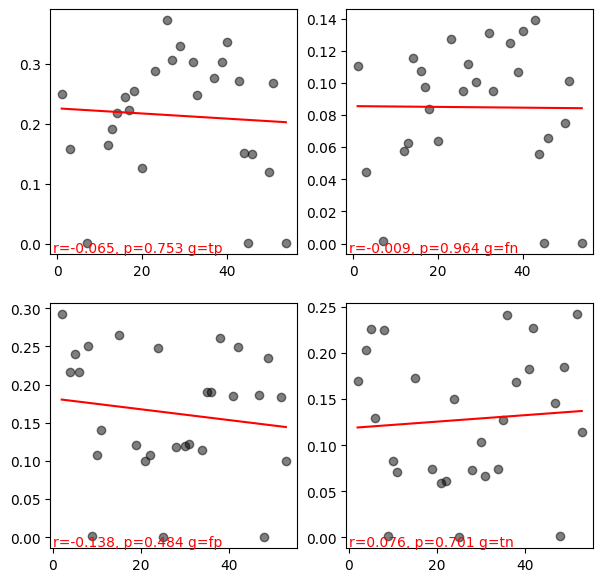

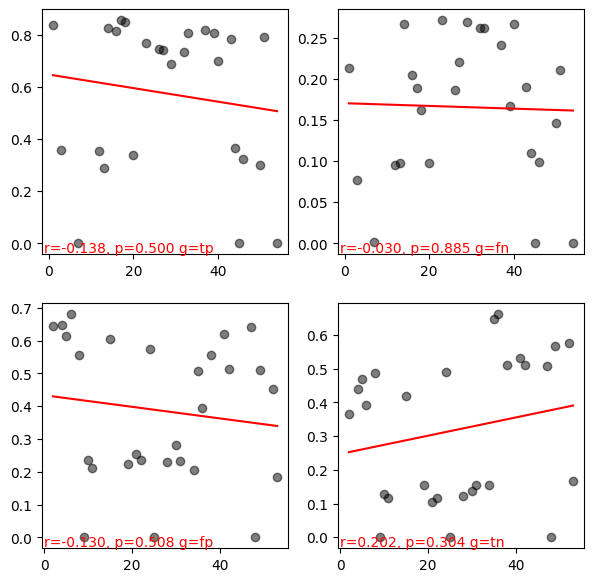

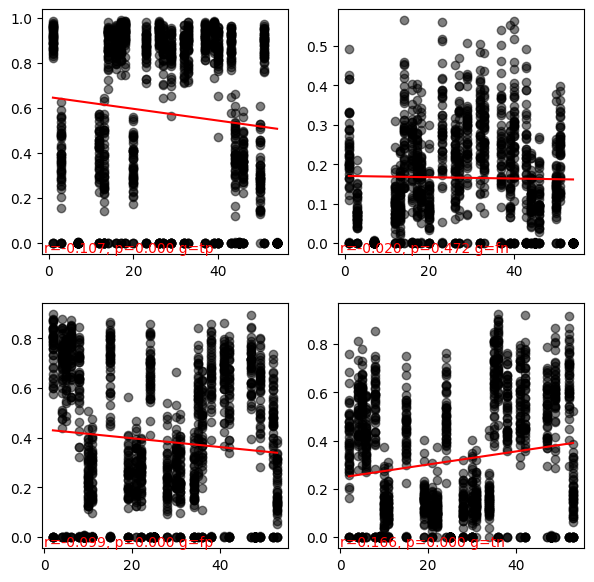

In [11]:
confusion_scatter(rand_mist, fan_type='both', aggregate='std')
confusion_scatter(rand_mist, fan_type='first', aggregate='mean')
confusion_scatter(rand_mist, fan_type='second', aggregate='none')